# Goal

We're going to build a FFN that can add two integers between -10 and +10. The input of the model will be two integers and the output should be their sum.

# Data

We build a dataset with N equations stored in a 3-column array.  
The first and second columns represent the two multipliers, and the third column is their product.  
All multipliers are sampled as integers from the range −10 to 10 (inclusive).  

We then train a simple feed-forward neural network to learn the multiplication rule.  
The network architecture is defined in the CreateNet() function:

Input layer: 2 neurons (for the two multipliers)  
Hidden layers: 16 → 32 → 64 neurons, each followed by ReLU activation  
Output layer: 1 neuron (predicting the product)  

Loss function: Mean Squared Error (MSE)  
Optimizer: Adam with learning rate = 0.01  

This setup allows the model to perform regression — predicting a continuous numerical value (the product) from two input numbers.


In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
N = 10000

mult = np.random.randint(-10,11,(N,2))
prod = mult[:,0] * mult[:,1]
prod = prod[:, None]
prod, mult = torch.tensor(prod).float(), torch.tensor(mult).float()
mult.shape, prod.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

# Split

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(mult, prod, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model

In [4]:
def CreateNet():

  class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(2, 16)

      self.fc1 = nn.Linear(16,32)
      self.fc2 = nn.Linear(32,64)

      self.output = nn.Linear(64,1)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return x

  net = Net()
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
  return net, loss_fn, optimizer

CreateNet()

(Net(
   (input): Linear(in_features=2, out_features=16, bias=True)
   (fc1): Linear(in_features=16, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=64, bias=True)
   (output): Linear(in_features=64, out_features=1, bias=True)
 ),
 MSELoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ))

In [5]:
net, loss_fn, optimizer = CreateNet()
X, y = next(iter(train_dataloader))
y_hat = net(X)
loss = loss_fn(y_hat, y)
mae = torch.mean(torch.abs(y_hat - y))
print(f'First spin MAE: {mae:.4f}')

First spin MAE: 26.5425


# Train

In [6]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_maes = []
  test_maes = []

  for epoch in range(epochs):
    net.train()

    batch_maes = torch.zeros(len(train_dataloader))
    batch_loss = []

    for batch, (X, y) in enumerate(train_dataloader):

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      batch_mae = torch.mean(torch.abs(y_hat - y))
      batch_maes[batch] = batch_mae
    # end of batch loop

    #training accuracy
    train_mae = torch.mean(batch_maes)
    train_maes.append(train_mae.item())

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)


    test_mae = torch.mean(torch.abs(y_hat - y))
    test_maes.append(test_mae.item())
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f} | Loss: {losses[epoch]:.2f}')

  return train_maes, test_maes, losses, net

In [7]:
train_maes, test_maes, losses, net = ModelTrain(epochs = 50, verbose = True)

Epoch: 0 | Train MAE: 8.71 | Test MAE: 5.30 | Loss: 191.78
Epoch: 10 | Train MAE: 0.77 | Test MAE: 0.57 | Loss: 1.07
Epoch: 20 | Train MAE: 0.78 | Test MAE: 0.57 | Loss: 1.18
Epoch: 30 | Train MAE: 0.55 | Test MAE: 0.38 | Loss: 0.58
Epoch: 40 | Train MAE: 0.52 | Test MAE: 0.42 | Loss: 0.52


# Plot

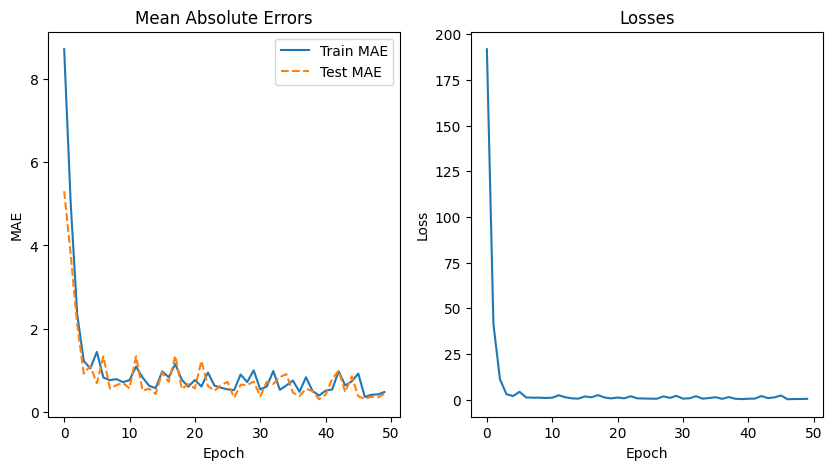

In [8]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_maes)
ax[0].plot(test_maes, '--')
ax[0].set_title('Mean Absolute Errors')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MAE')
ax[0].legend(['Train MAE', 'Test MAE'])

ax[1].plot(losses.detach())
ax[1].set_title('Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.show()

# Predictions

Let's generate new test set

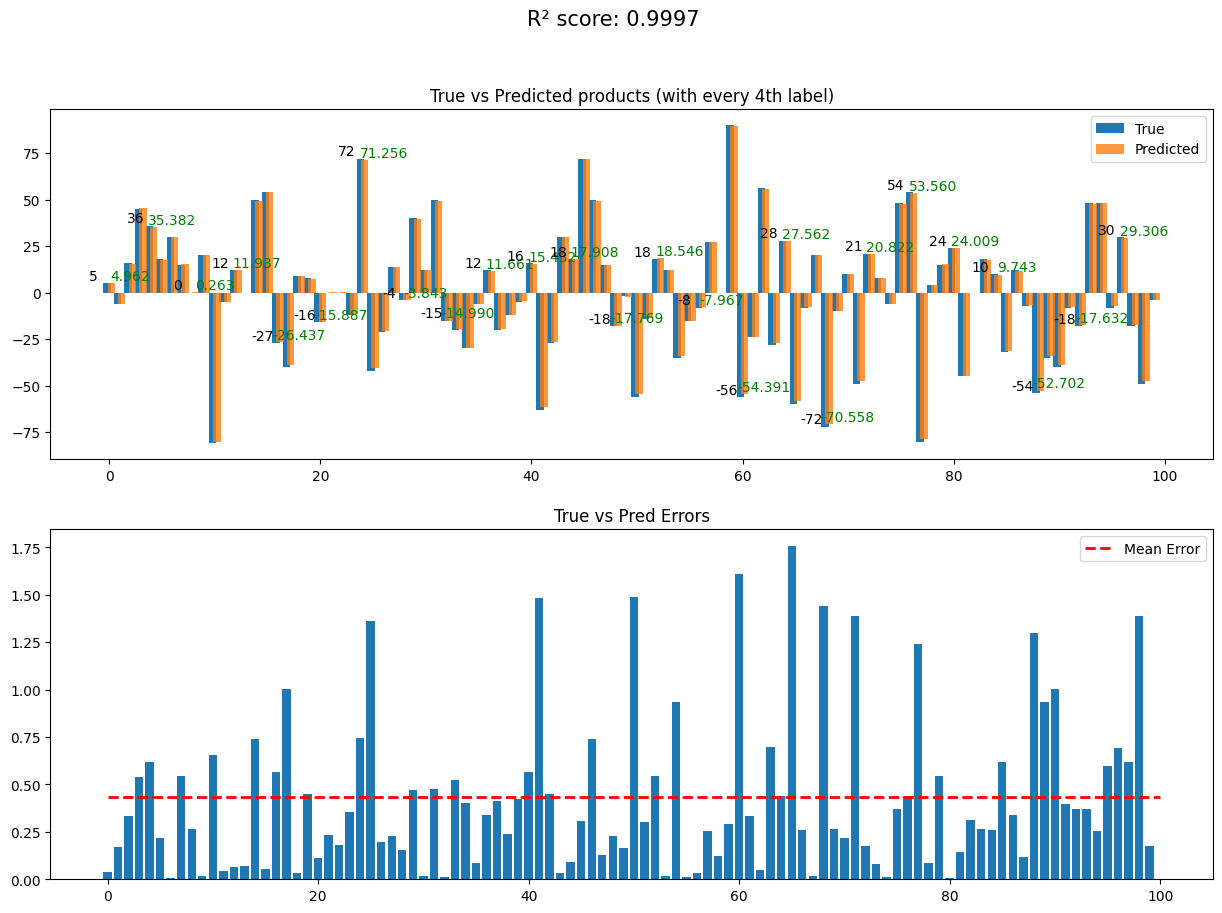

In [46]:
N = 100
# Preds
test_mult = np.random.randint(-10,10,(N, 2))
test_mult = torch.tensor(test_mult).float()
true_prods = (test_mult[:,0] * test_mult[:,1])[:,None]
pred_prods = net(test_mult)

# R2
y = true_prods
y_hat = pred_prods.detach()
ss_res = torch.sum((y - y_hat) ** 2)
ss_tot = torch.sum((y - torch.mean(y)) ** 2)
r2 = 1 - ss_res / ss_tot


fig, ax = plt.subplots(2, 1, figsize=(15,10))

ax[0].bar(np.arange(N) - 0.2, true_prods.squeeze(), width=0.7, label='True')
ax[0].bar(np.arange(N) + 0.2, pred_prods.squeeze().detach(), width=0.7, label='Predicted', alpha =.8)
for x, t, p in zip(np.arange(N), true_prods.squeeze(), pred_prods.squeeze().detach()):
  if x%4 == 0:
    ax[0].text(x - 1.5, t, f'{int(t)}', ha = 'center', va = 'bottom')
    ax[0].text(x + 2, p, f'{p:.3f}', ha = 'center', va = 'bottom', color = 'green')
ax[0].legend()
ax[0].set_title("True vs Predicted products (with every 4th label)")

diffs = abs(true_prods.squeeze() - pred_prods.squeeze())
ax[1].bar(np.arange(N), diffs.detach())
m = torch.mean(diffs.detach())
ax[1].plot([0, N], [m,m], 'r--', label = 'Mean Error', linewidth = 2)
ax[1].legend()
ax[1].set_title('True vs Pred Errors')

plt.suptitle(f"R² score: {r2.item():.4f}", fontsize = 15)
plt.show()

Now let's see how model is able to predict specificially equation that was not present in the training dataset.

In [56]:
a, b = 11, -11
# model
test = torch.tensor([a, b]).float()
pred = net(test)
# true multiplication
true_value = a*b

print(f'Product of multiplication: {a} x {b} = {true_value}, and our model predicted {pred.item():.3f}. The difference is equal to {abs(true_value - pred.detach().item()):.3f}')

Product of multiplication: 11 x -11 = -121, and our model predicted -113.993. The difference is equal to 7.007


# Conclusion

The blue bars (True) and orange bars (Predicted) overlap almost perfectly, showing that the model’s predictions match the true values very closely.

The R² score of 0.9995 indicates that 99.95% of the variance in the true data is explained by the model’s predictions. This means the network has effectively learned the underlying mathematical relationship y = x1 * x2 rather than just memorizing training examples.

In other words, the model performs an almost perfect regression fit to the multiplication function.
